In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
## for correlation matrices
import seaborn as sns
%matplotlib inline
## for linear models
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ConfusionMatrix


from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE



In [70]:
# Must download from http://web.stanford.edu/group/deepsolar/deepsolar_tract.csv and delete the first ","
df = pd.read_csv("deepsolar_tract.csv", encoding = "utf-8")


In [71]:
# Remove all deepsolar inputs

df = df.drop(columns=['solar_system_count'], axis = 1)
df = df.drop(columns=['total_panel_area'], axis = 1)
df = df.drop(columns=['solar_panel_area_per_capita'], axis =1)

df = df.drop(columns=['solar_panel_area_divided_by_area'], axis = 1)
df = df.drop(columns=['tile_count_residential'], axis = 1)
df = df.drop(columns=['tile_count_nonresidential'], axis = 1)
df = df.drop(columns=['solar_system_count_residential'], axis =1)

df = df.drop(columns=['solar_system_count_nonresidential'], axis = 1)
df = df.drop(columns=['total_panel_area_residential'], axis = 1)
df = df.drop(columns=['total_panel_area_nonresidential'], axis = 1)
df = df.drop(columns=['number_of_solar_system_per_household'], axis =1)

# Remove all unique identifiers, objects, and booleans
df = df.drop(columns=['county',
                      'state',
                     'electricity_price_transportation',
                     'voting_2016_dem_win',
                     'voting_2012_dem_win',
                     'fips'])



In [29]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72537 entries, 0 to 72537
Data columns (total 168 columns):
tile_count                                 float64
solar_system_count                         float64
total_panel_area                           float64
fips                                       int64
average_household_income                   float64
county                                     object
education_bachelor                         int64
education_college                          int64
education_doctoral                         int64
education_high_school_graduate             int64
education_less_than_high_school            int64
education_master                           int64
education_population                       int64
education_professional_school              int64
employed                                   int64
gini_index                                 float64
heating_fuel_coal_coke                     int64
heating_fuel_electricity                   int

In [6]:
df.population_density.median()

2225.731

### Logistic Regression Option 1: Creating target (does the county subdivision census tract have any solar panels within it) 

In [72]:
# tilesLargerThanZero = range(1,4469)
df_mm['has_tiles'] = (df.tile_count > 0).mul(1)

In [73]:
df_mm.has_tiles.value_counts()

1    41601
0    12498
Name: has_tiles, dtype: int64

In [20]:
df_mm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54099 entries, 0 to 54098
Columns: 151 entries, average_household_income to has_tiles
dtypes: float64(150), int32(1)
memory usage: 62.1 MB


### Logistic Regression Option 2: Creating target (does the county subdivision census tract have more than the median amount of solar panels within it)

In [9]:
tilesInLargerHalf = range(4,4469)

In [50]:
# df.tile_count = df['tile_count'].replace([1,2,3], 0)
# df.tile_count = df['tile_count'].replace(tilesInLargerHalf, 1)

df_mm['has_tiles'] = (df.tile_count <= 30).mul(0)
df_mm['has_tiles'] = (df.tile_count > 30).mul(1)

# Check to see target values

In [67]:
df_mm.has_tiles.value_counts()

1    31570
0    22529
Name: has_tiles, dtype: int64

# Create a dataframe with only features that have no NaN
Note: This didn't work because I don't know the ratio for each census tract (county subdivision) 

In [419]:
no_NaN_df = pd.DataFrame()
for lessNaN in df.columns:
    if df[lessNaN].isnull().sum().sum() < 1:
        no_NaN_df[lessNaN] = df[lessNaN]

# df = df.dropna(axis = 1)

In [420]:
no_NaN_df.columns

Index(['tile_count', 'fips', 'education_bachelor', 'education_college',
       'education_doctoral', 'education_high_school_graduate',
       'education_less_than_high_school', 'education_master',
       'education_population', 'education_professional_school', 'employed',
       'heating_fuel_coal_coke', 'heating_fuel_electricity',
       'heating_fuel_fuel_oil_kerosene', 'heating_fuel_gas',
       'heating_fuel_housing_unit_count', 'heating_fuel_none',
       'heating_fuel_other', 'heating_fuel_solar', 'population',
       'poverty_family_below_poverty_level', 'poverty_family_count',
       'race_asian', 'race_black_africa', 'race_indian_alaska',
       'race_islander', 'race_other', 'race_two_more', 'race_white',
       'unemployed', 'electricity_price_residential',
       'electricity_price_commercial', 'electricity_price_industrial',
       'electricity_price_overall', 'electricity_consume_residential',
       'electricity_consume_commercial', 'electricity_consume_industrial',
    

In [421]:
educationDF = pd.DataFrame()
educationDF['education_less_than_high_school'] = no_NaN_df['education_less_than_high_school']
educationDF['education_doctoral'] = no_NaN_df['education_doctoral']
educationDF['education_bachelor'] = no_NaN_df['education_bachelor']


In [494]:
df = df.dropna()

# Picking Features

In [12]:
df.per_capita_income.isnull().sum()


643

In [74]:
refined_cols = ['population_density', 'net_metering', 'frost_days', 'daily_solar_radiation', 'relative_humidity','heating_degree_days', 'earth_temperature','has_tiles']
chosen_from_lasso = ['education_bachelor', 'employed', 'education_high_school_graduate_rate',
       'heating_fuel_coal_coke_rate', 'relative_humidity',
       'occupancy_vacant_rate', 'mortgage_with_rate',
       'incentive_count_residential', 'has_tiles']

In [75]:
pickedDF = pd.DataFrame()
pickedDF[chosen_from_lasso] = df_mm[chosen_from_lasso]

In [76]:
pickedDF.head()

,education_bachelor,employed,education_high_school_graduate_rate,heating_fuel_coal_coke_rate,relative_humidity,occupancy_vacant_rate,mortgage_with_rate,incentive_count_residential,has_tiles
0,569,3569,0.386324,0.079145,0.695,0.137837,0.627580,34,0
2,854,3550,0.343973,0.025574,0.695,0.072534,0.640390,34,1
3,640,3483,0.316840,0.102564,0.695,0.176550,0.637734,34,0
4,654,2887,0.293309,0.050078,0.695,0.043413,0.601471,34,1
5,522,3270,0.425809,0.027108,0.694,0.066432,0.609838,34,0


# Starting to run Logistic Regression

In [59]:
pickedDF.has_tiles.value_counts()

0    40799
1    13300
Name: has_tiles, dtype: int64

In [78]:
# Define X and y
y = pickedDF['has_tiles']
X = pickedDF.drop('has_tiles', axis = 1)
# Split the data into training and test sets
# from sklearn.model_selection import train_test_split

#ADD STRATIFIED HERE

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
print(y_train.value_counts(),'\n\n', y_test.value_counts())

# SMOTE
# smt = SMOTE()
# X_train, y_train = smt.fit_sample(X_train, y_train)
# print(y_train.value_counts(),'\n\n', y_test.value_counts())

1    31209
0     9365
Name: has_tiles, dtype: int64 

 1    10392
0     3133
Name: has_tiles, dtype: int64


# Continue From here standardize and see if different from before. 

# Exploring Min Max Scaling

In [61]:
df_mm = df.dropna()

In [62]:
df_mm = df_mm.drop('has_tiles', axis = 1)
col_names = list(df_mm.columns)
mm_scaler = preprocessing.MinMaxScaler()
x_train = mm_scaler.fit_transform(df_mm)
x_test = mm_scaler.transform(df_mm)
x_train = pd.DataFrame(df_mm, columns=col_names)

KeyError: "['has_tiles'] not found in axis"

In [63]:
#stratify 

In [164]:
lab_enc = preprocessing.LabelEncoder()
y_train = lab_enc.fit_transform(y_train)

### Insert Pipeline HERE? 

# Use GridSearchCV to optimize hyper parameters 

In [64]:
parameters = {'penalty':['l1', 'l2'], 'C':[.001,.01,100, 10,1e9]}
#clf = classifier
clf = GridSearchCV(LogisticRegression(solver='saga'), parameters, cv = 5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 100, 10, 1000000000.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [66]:
print(clf.best_params_)

{'C': 10, 'penalty': 'l1'}


# Compare train and test data logreg for fit

In [67]:
print(clf.score(X_train, y_train))

0.5467567214826416


In [68]:
print(clf.score(X_test, y_test))

0.5804066543438078


Train AUC: 0.5614921078497204
Test AUC: 0.5571378994024843


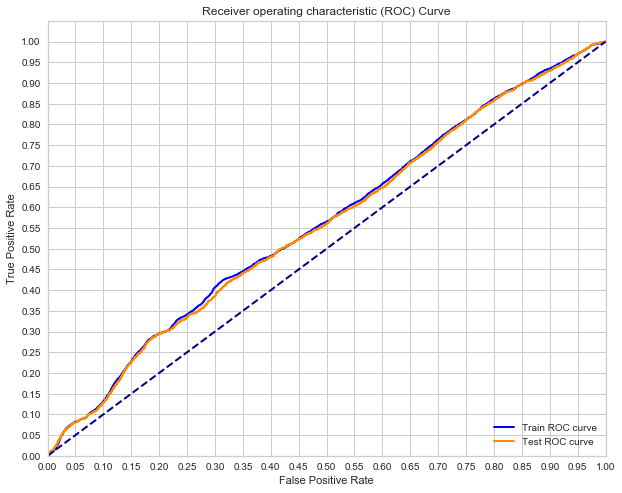

In [24]:
y_train_score = clf.decision_function(X_train)
y_test_score = clf.decision_function(X_test)

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Use Confusion Matrix to visualize results.

C:\Users\BudBe\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


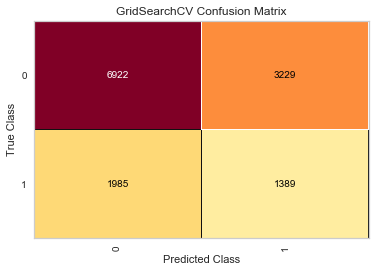

In [27]:
cm = ConfusionMatrix(clf)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

In [26]:
clf.

SyntaxError: invalid syntax (<ipython-input-26-8097f1fc138e>, line 1)

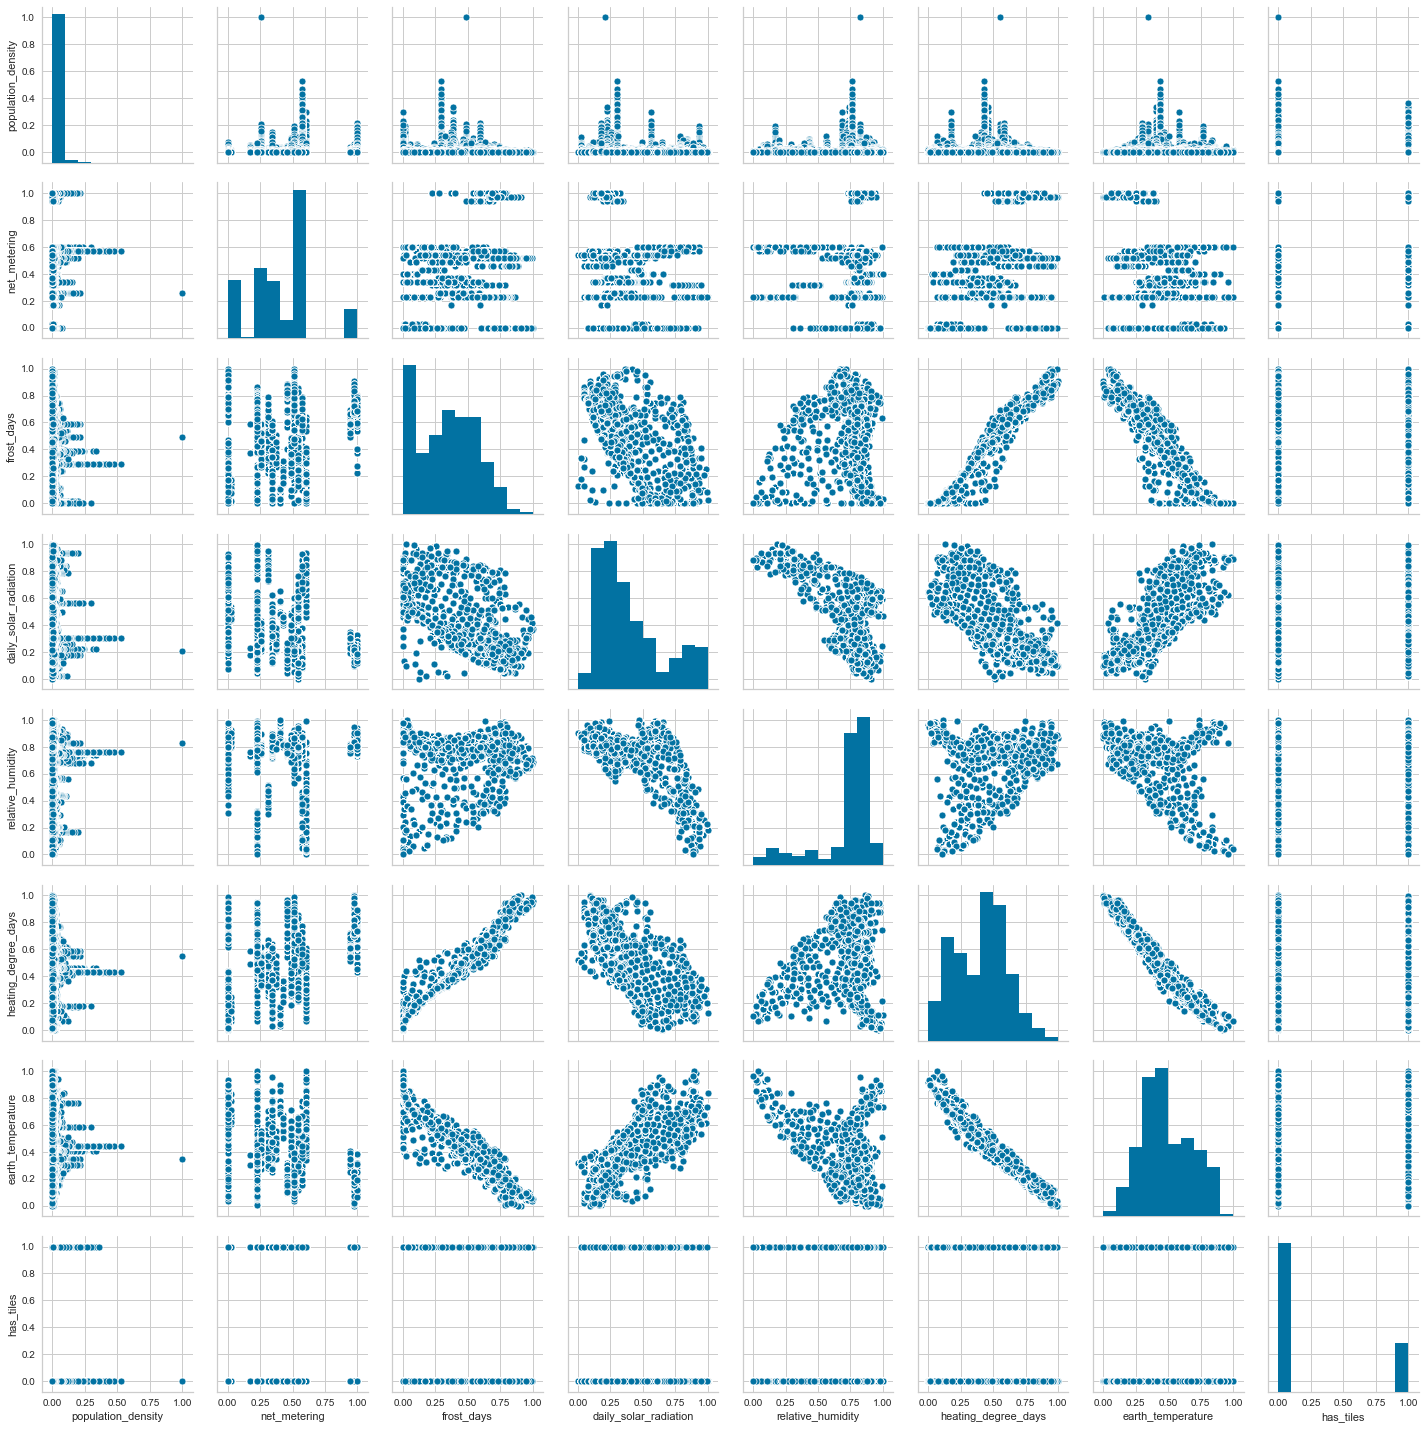

In [179]:
sns.pairplot(pickedDF[refined_cols]);

# Support Documentation 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
print(clf.best_params_)

https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
SMOTE Example

https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html

http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/

